In [3]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, lfilter
from scipy.signal import freqz

FS = 250

In [5]:
subjectData = {}

In [6]:
ns = 10

# data_path = os.path.join("A{:02d}T.npz".format(1))
for i in range(1,ns):
    data_path = os.path.join("A{:02d}T.npz".format(i))
    subject = 'subject{:02d}'.format(i)

    subjectData[subject] = np.load(data_path)

In [7]:
print(type(subjectData['subject01']))
print(subjectData['subject01'].files)


<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


s: contains time-series recorded EEG signals of shape MxN array. N is the number of electrodes (22 EEG and 3 EOG), M can vary

etpye: event type to indicate event occurence

epos: event position denoting event start at s


edur: event duration artifacts: size of 288x1, 6x48 = 288 where 6 is the number of runs with 48 trials. 48 trials have 12 trials of 4 class each

In [8]:
print('Sample\t Electrodes')
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    print('subject{:02d}'.format(i), subjectData[sub]['s'].shape)

Sample	 Electrodes
subject01 (672528, 25)
subject02 (677169, 25)
subject03 (660530, 25)
subject04 (600915, 25)
subject05 (686120, 25)
subject06 (678980, 25)
subject07 (681071, 25)
subject08 (675270, 25)
subject09 (673328, 25)


In [9]:
# Bandpass filter
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b,a,signal, axis=-1)
    return y

In [10]:
def butterFilter(cleanData, data, sub):
    lowcut = 4
    highcut = 40
    fs = 250
    print('Processing', sub)
    cleanData[sub] = butter_bandpass_filter(data, lowcut, highcut, fs)

In [11]:
# Transpose the raw EEG data to apply filtering on the time-series axis
rawData = {}
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    rawData[sub] = subjectData[sub]['s'].T

    print('subject{:02d}'.format(i), rawData[sub].shape)

# rawData

subject01 (25, 672528)
subject02 (25, 677169)
subject03 (25, 660530)
subject04 (25, 600915)
subject05 (25, 686120)
subject06 (25, 678980)
subject07 (25, 681071)
subject08 (25, 675270)
subject09 (25, 673328)


In [10]:
cleanEEG = {}
for i in range(1,ns):
    sub = 'subject{:02d}'.format(i)
    butterFilter(cleanEEG, rawData[sub], sub)

    print(cleanEEG[sub].shape)

Processing subject01
(25, 672528)
Processing subject02
(25, 677169)
Processing subject03
(25, 660530)
Processing subject04
(25, 600915)
Processing subject05
(25, 686120)
Processing subject06
(25, 678980)
Processing subject07
(25, 681071)
Processing subject08
(25, 675270)
Processing subject09
(25, 673328)


There are 4 classes with event code as 769, 770, 771, 772 for left, right, foot and tongue.

In [23]:
left_class_code = 769
right_class_code = 770
foot_class_code = 771
tongue_class_code = 772

for i in range(1,2):
    sub = 'subject{:02d}'.format(i)
    right_dur = subjectData[sub]['epos'][subjectData[sub]['edur'] == right_class_code]
    left = subjectData[sub]['epos'][subjectData[sub]['etyp'] == left_class_code]
    right = subjectData[sub]['epos'][subjectData[sub]['etyp'] == right_class_code]
    foot = subjectData[sub]['epos'][subjectData[sub]['etyp'] == foot_class_code]
    tongue = subjectData[sub]['epos'][subjectData[sub]['etyp'] == tongue_class_code]



In [24]:
right_dur

array([], dtype=int32)

These are the sample points where the event has started

Steps to start with

1. Remove EOG channels from all subjects

2. Crop the data for each subject such that you get the data during the motor imagery peroid (refer Experimental_Paradigm)


In [15]:
print(subjectData['subject01'].files)

# print(subjectData['subject01']['s'])
# print(subjectData['subject02']['etyp'])
# print(subjectData['subject02']['epos'])
# print(len(subjectData['subject02']['edur']))
# print((subjectData['subject02']['etyp']))


['s', 'etyp', 'epos', 'edur', 'artifacts']


In [16]:
def preprocess_subject_data(subject_data):
    eeg_data = subject_data['s'][:, :22]  # Keep only EEG channels, so first 22 channels
    eeg_data = butter_bandpass_filter(eeg_data, 4, 40, 250)  # Filtered signal; note: 250 = frequency signal
    return eeg_data

processed_data = preprocess_subject_data(subjectData['subject01'])

# print(processed_data.files)

print(processed_data)

[[-0.12413272 -0.97239483 -3.48768025 ...  4.38812515  3.51662096
   4.28496359]
 [-0.12871961 -1.00462194 -3.60365294 ...  2.95697117  2.62593275
   3.99382314]
 [-0.0917378  -0.73169314 -2.68264345 ...  1.10543494  1.41723633
   3.51528   ]
 ...
 [ 0.03239491  0.2791169   1.13517762 ...  1.4068474   0.14132073
  -1.84857238]
 [ 0.00860042  0.07579908  0.34366195 ...  1.19321182  1.23769793
  -0.45890977]
 [ 0.00802706  0.07452999  0.34174108 ... -0.57122735  0.15591882
  -1.14051005]]


(672528, 22)
(672528,)


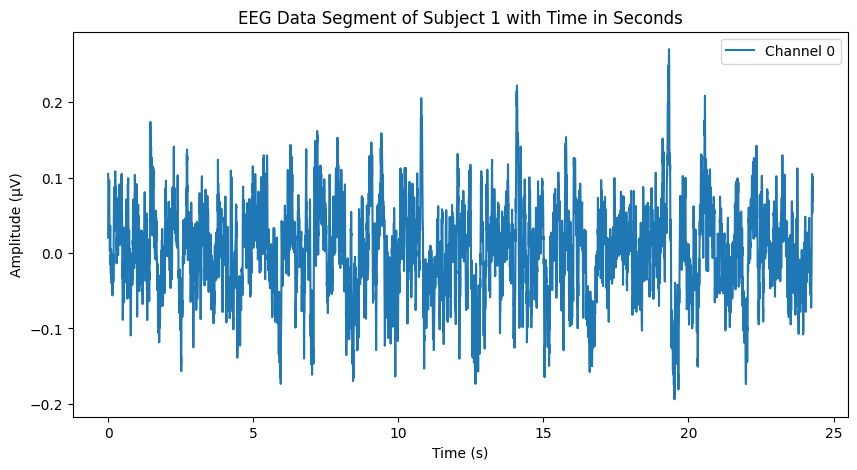

In [22]:
subject = f'subject{1:02d}'
eeg_data = preprocess_subject_data(subjectData[subject])
start, end = right[0], right[1]

print(eeg_data.shape)
temp = eeg_data[:, 0] # only gets 0th channel from eeg_data

print(temp.shape)

segments_of_temp2 = eeg_data[start:end, :]
time_axis = np.arange(0, len(segments_of_temp2)) / FS

plt.figure(figsize=(10, 5))
for i in range(1): # plot only first channel (0th channel) from eeg_data of subject1
    plt.plot(time_axis, segments_of_temp2[:,0], label = f"Channel {i}")

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title("EEG Data Segment of Subject 1 with Time in Seconds")
plt.legend()
plt.show()


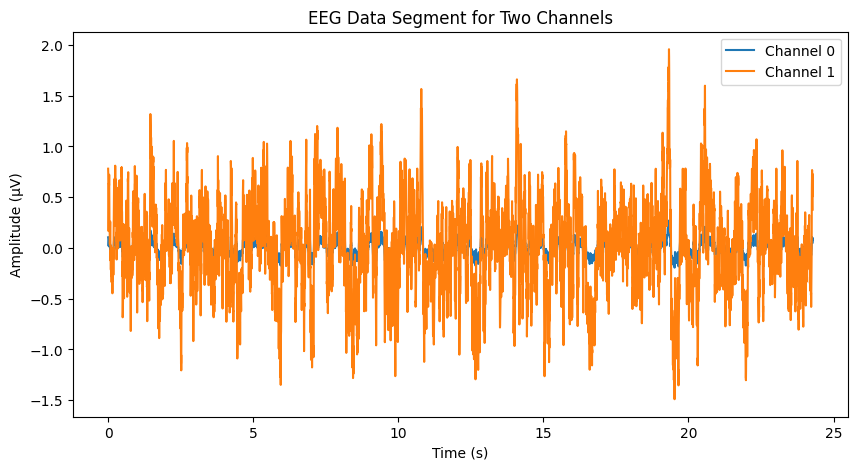

In [74]:
subject = f'subject{1:02d}'
eeg_data = preprocess_subject_data(subjectData[subject])

# Extract a segment of the first two channels (0 and 1) between the right-hand motor imagery events
temp2 = eeg_data[:, :2]  # Select channels 0 and 1
start, end = right[0], right[1]
segment_of_temp2 = temp2[start:end, :]  # Get the segment for both channels

# Create a time axis in seconds
FS = 250  # Sampling rate in Hz
time_axis = np.arange(0, len(segment_of_temp2)) / FS

# Plot the two channels
plt.figure(figsize=(10, 5))
plt.plot(time_axis, segment_of_temp2[:, 0], label="Channel 0")  # Plot channel 0
plt.plot(time_axis, segment_of_temp2[:, 1], label="Channel 1")  # Plot channel 1
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title("EEG Data Segment for Two Channels")
plt.legend()  # Show legend to identify channels
plt.show()